# Secure and Robust AI Model Development (2025, DAT945)


## Imports, device, seed, helpers

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import random, copy, numpy as np, torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = {
    "num_clients": 10,
    "frac_participate": 0.3,
    "rounds": 20,
    "local_epochs": 1,
    "batch_size": 64,
    "lr": 0.01,
    "momentum": 0.0,
    "weight_decay": 0.0,
    "noniid": False,
    "alpha": 0.5,  # for dirichlet
}


## Simple Feedforward Network for MNIST (2 hidden layers)

In [124]:
class SimpleFFN(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [138]:
model = SimpleFFN().to(device)
print(model)
# Dummy input and target
x = torch.randn(5, 784).to(device)   # batch_size=5, input_dim=784
y = torch.randn(5, 10).to(device)    # target with same shape as output
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
outputs = model(x)
loss = criterion(outputs, y)
optimizer.zero_grad()
loss.backward()

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"layer: {name}, weight_shape: {param.data.shape}, grad_shape: {param.grad.shape}")
        print("weight", param.data)
        print("grad", param.grad)


SimpleFFN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
layer: fc1.weight, weight_shape: torch.Size([256, 784]), grad_shape: torch.Size([256, 784])
weight tensor([[-0.0183, -0.0183,  0.0160,  ..., -0.0045, -0.0282, -0.0041],
        [ 0.0006, -0.0274,  0.0354,  ..., -0.0216,  0.0183, -0.0174],
        [-0.0107,  0.0217, -0.0083,  ..., -0.0134, -0.0007,  0.0257],
        ...,
        [-0.0128,  0.0072,  0.0150,  ..., -0.0178,  0.0309,  0.0199],
        [ 0.0205, -0.0076, -0.0092,  ...,  0.0153, -0.0141,  0.0284],
        [-0.0057,  0.0031,  0.0018,  ..., -0.0342,  0.0058, -0.0014]])
grad tensor([[-1.0719e-02,  1.0675e-02, -3.0757e-02,  ...,  4.2863e-03,
         -9.4275e-03,  8.1376e-03],
        [-7.2380e-03, -2.1563e-02,  3.1134e-02,  ..., -2.2641e-02,
         -2.9406e-03,  6.6570e-03],
        [ 7.8936e-03, -2.3911e-03,  3.0161e-03,  ..., -3.9

## Load MNIST and create partitions (IID, non-IID)

In [126]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


# low alpha -> high heterogeneity (non-iid)
# high alpha -> low heterogeneity (iid)
def create_dirichlet_partitions(dataset, num_clients, alpha=0.5):
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    
    class_idx = [np.where(targets == y)[0] for y in range(num_classes)]
    client_idx = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        np.random.shuffle(class_idx[c])
        proportions = np.random.dirichlet(alpha=[alpha]*num_clients)
        proportions = (np.cumsum(proportions) * len(class_idx[c])).astype(int)[:-1]
        split = np.split(class_idx[c], proportions)
        for i in range(num_clients):
            client_idx[i].extend(split[i].tolist())
    return client_idx

def make_client_loaders(train_partitions, batch_size):
    loaders = []
    for idxs in train_partitions:
        subset = Subset(train_set, idxs)
        loaders.append(DataLoader(subset, batch_size=batch_size, shuffle=True))
    return loaders

test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

def build_clients(num_clients, alpha=0.5, batch_size=64):
    
    parts = create_dirichlet_partitions(train_set, num_clients, alpha)
    
    return make_client_loaders(parts, batch_size), [len(p) for p in parts]


## Helpers to compute and visualize client label distributions

In [127]:

import matplotlib.pyplot as plt
import numpy as np

def _get_targets_array(dataset):
    t = getattr(dataset, "targets", None)
    if t is None:
        t = getattr(dataset, "labels", None)
    if hasattr(t, "numpy"):
        t = t.numpy()
    return np.asarray(t)

def client_class_counts(partitions, dataset, num_classes=10):
    targets = _get_targets_array(dataset)
    counts = np.zeros((len(partitions), num_classes), dtype=int)
    for i, idxs in enumerate(partitions):
        lbls, cts = np.unique(targets[idxs], return_counts=True)
        counts[i, lbls.astype(int)] = cts
    return counts



def plot_client_bar_grid(counts, ncols=5, max_clients=None, title="Client distributions"):
    num_clients = counts.shape[0]
    if max_clients is not None:
        num_clients = min(num_clients, max_clients)
    nrows = int(np.ceil(num_clients / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2.5*nrows), squeeze=False)
    axes = axes.flatten()

    for i in range(num_clients):
        ax = axes[i]
        ax.bar(np.arange(counts.shape[1]), counts[i])
        ax.set_title(f"Client {i}")
        ax.set_xticks(range(counts.shape[1]))
        ax.set_ylim(0, counts.max() * 1.1)

    
    for j in range(num_clients, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


## Local training and evaluation

In [128]:

def local_train(model, loader, epochs, lr, momentum, weight_decay, device):
    # Initialize a local model with the global model weights
    model = copy.deepcopy(model)
    model.train()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            
            # Forward pass
            y_hat = model(x)

            # Compute loss
            loss = criterion(y_hat, y)
            
            # Backward pass
            loss.backward()

            # Update model parameters
            opt.step()
    # Return the updated (trainable) parameters
    return model.state_dict()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += criterion(logits, y).item()
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total


## FedAvg

In [129]:

def fedavg(global_model, client_loaders, client_sizes, cfg):
    num_clients = len(client_loaders)
    m = max(1, int(cfg["frac_participate"] * num_clients))
    acc=[]
    for rnd in range(1, cfg["rounds"] + 1):
        selected = np.random.choice(num_clients, m, replace=False)
        
        total_samples = sum(client_sizes[i] for i in selected)
        new_state = None
        for i in selected:
            local_state = local_train(global_model, client_loaders[i],
                                      cfg["local_epochs"], cfg["lr"], cfg["momentum"], cfg["weight_decay"], device)
            # Uniform averaging (e.g., 10 client case weight=0.1)
            weight = 1 / len(selected)
            if new_state is None:
                new_state = {k: v.clone().float() * weight for k, v in local_state.items()}
            else:
                for k in new_state.keys():
                    new_state[k] += local_state[k].float() * weight
        
        global_model.load_state_dict(new_state)
        test_loss, test_acc = evaluate(global_model, test_loader, device)
        print(f"Round {rnd:03d} | test_acc={test_acc:.4f} | test_loss={test_loss:.4f} | selected_clients={selected}")
        acc.append(test_acc)

    return global_model, acc


## Run IID case

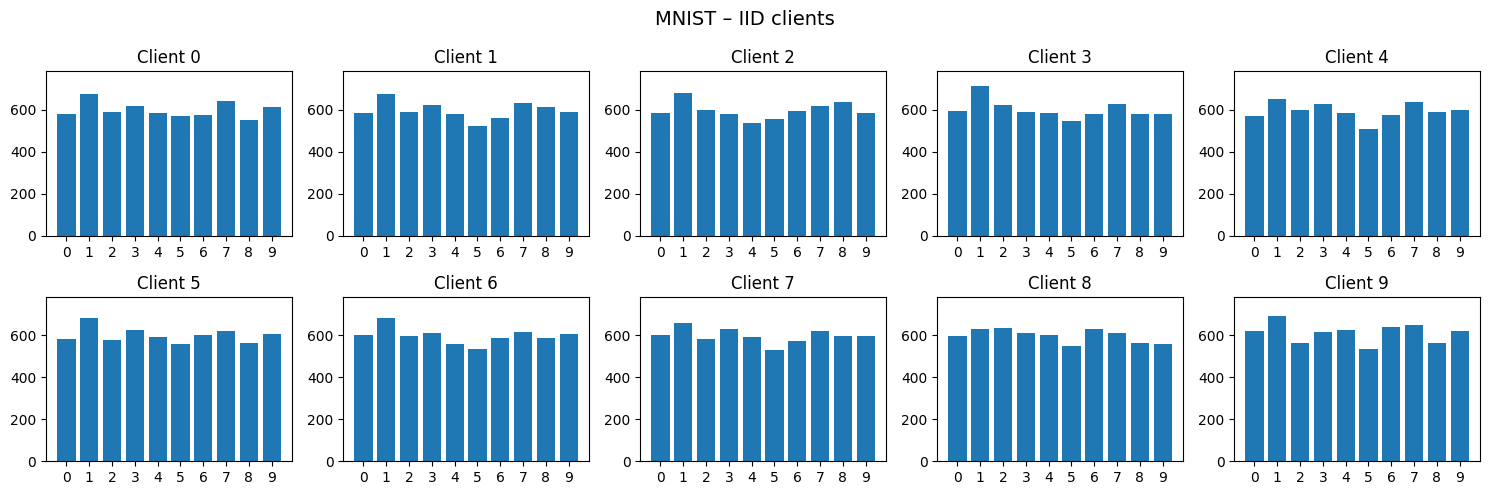

SimpleFFN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
=== IID Training (MNIST + FFN) ===
Round 001 | test_acc=0.5751 | test_loss=1.9518 | selected_clients=[7 4 2]
Round 002 | test_acc=0.7701 | test_loss=1.2110 | selected_clients=[9 2 8]
Round 003 | test_acc=0.8239 | test_loss=0.7557 | selected_clients=[7 3 0]
Round 004 | test_acc=0.8535 | test_loss=0.5720 | selected_clients=[2 3 8]
Round 005 | test_acc=0.8738 | test_loss=0.4838 | selected_clients=[3 4 0]
Round 006 | test_acc=0.8857 | test_loss=0.4320 | selected_clients=[7 6 0]
Round 007 | test_acc=0.8943 | test_loss=0.3944 | selected_clients=[6 9 7]
Round 008 | test_acc=0.8979 | test_loss=0.3691 | selected_clients=[3 8 5]
Round 009 | test_acc=0.9007 | test_loss=0.3524 | selected_clients=[6 4 1]
Round 010 | test_acc=0.9063 | test_loss=0.3364 | selected_clients=[6 3 1]
Round 011 | test_acc=0.9073

In [130]:


cfg.update({"noniid": True, "alpha":1000})
clients_iid, sizes_iid = build_clients(
    num_clients=cfg["num_clients"],
    alpha=cfg["alpha"],
    batch_size=cfg["batch_size"]
)
# For IID clients
counts_iid = client_class_counts([p.indices for p in [loader.dataset for loader in clients_iid]], train_set, num_classes=10)
plot_client_bar_grid(counts_iid, ncols=5, title="MNIST – IID clients")





model_iid = SimpleFFN().to(device)
print(model_iid)
print("=== IID Training (MNIST + FFN) ===")
_, acc_iid = fedavg(model_iid, clients_iid, sizes_iid, cfg)



## Run Non-IID case

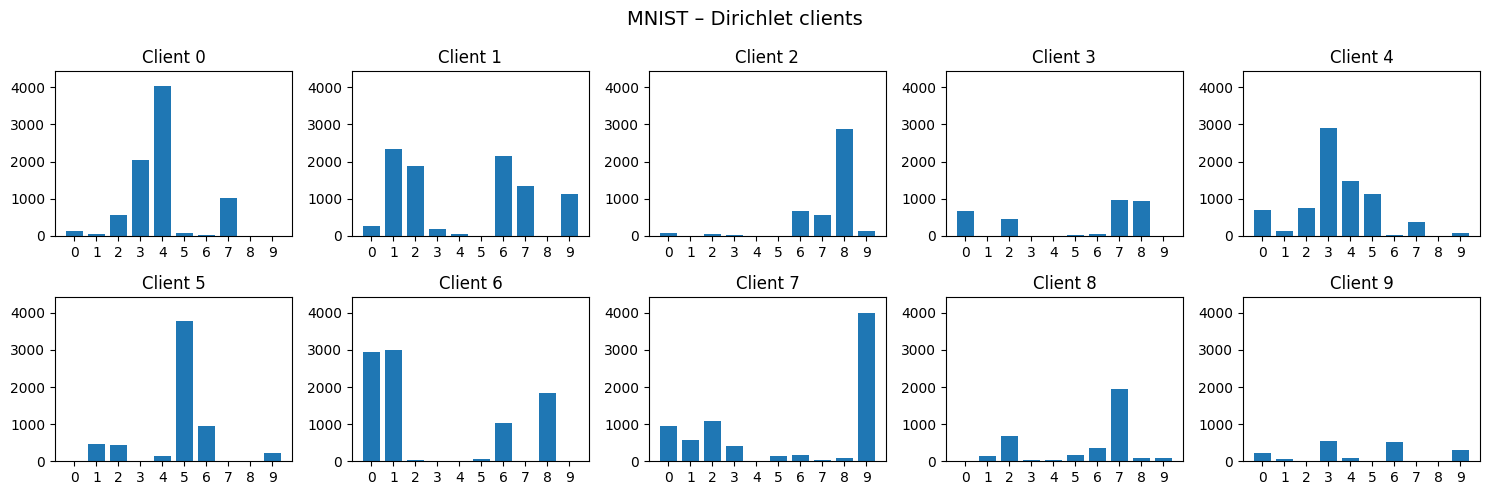

=== Dirichlet Non-IID Training (MNIST + FFN) ===
Round 001 | test_acc=0.3720 | test_loss=2.1189 | selected_clients=[8 4 9]
Round 002 | test_acc=0.4387 | test_loss=1.9793 | selected_clients=[0 1 4]
Round 003 | test_acc=0.6045 | test_loss=1.3583 | selected_clients=[0 2 1]
Round 004 | test_acc=0.7300 | test_loss=0.9621 | selected_clients=[8 4 7]
Round 005 | test_acc=0.6739 | test_loss=0.9346 | selected_clients=[2 5 3]
Round 006 | test_acc=0.6736 | test_loss=0.9272 | selected_clients=[2 6 1]
Round 007 | test_acc=0.7056 | test_loss=0.7636 | selected_clients=[8 0 9]
Round 008 | test_acc=0.8285 | test_loss=0.5725 | selected_clients=[7 0 2]
Round 009 | test_acc=0.7503 | test_loss=0.6678 | selected_clients=[0 9 3]
Round 010 | test_acc=0.7442 | test_loss=0.6821 | selected_clients=[3 7 1]
Round 011 | test_acc=0.8162 | test_loss=0.5404 | selected_clients=[8 0 6]
Round 012 | test_acc=0.7806 | test_loss=0.6265 | selected_clients=[6 3 9]
Round 013 | test_acc=0.7850 | test_loss=0.5657 | selected_clien

In [131]:

cfg.update({"noniid": True, "alpha": 0.3})

clients_dir, sizes_dir = build_clients(
    num_clients=cfg["num_clients"],
    alpha=cfg["alpha"],
    batch_size=cfg["batch_size"],
)
# For Dirichlet clients
counts_dir = client_class_counts([p.indices for p in [loader.dataset for loader in clients_dir]], train_set, num_classes=10)
plot_client_bar_grid(counts_dir, ncols=5, title="MNIST – Dirichlet clients")


model_dir = SimpleFFN().to(device)
print("=== Dirichlet Non-IID Training (MNIST + FFN) ===")
_, acc_non_iid = fedavg(model_dir, clients_dir, sizes_dir, cfg)


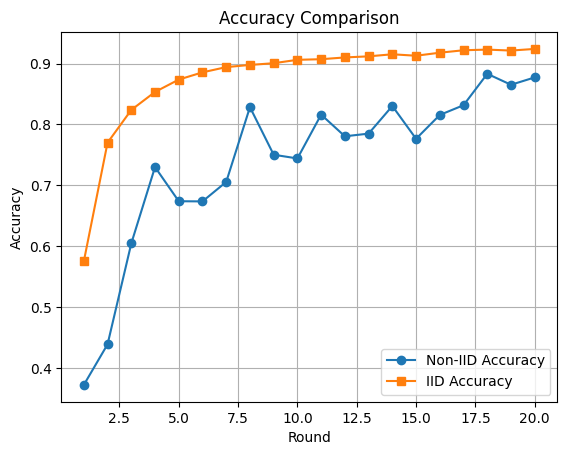

In [ ]:


# Example accuracy lists
epochs = range(1, len(acc_non_iid) + 1)

plt.plot(epochs, acc_non_iid, marker='o', label='Non-IID Accuracy')
plt.plot(epochs, acc_iid, marker='s', label='IID Accuracy')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()
